In [1]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import os
import tarfile
import scipy.io
from shutil import copyfile

# Paths
base_dir = "/content/"
images_tar_path = os.path.join(base_dir, "102flowers.tgz")
labels_path = os.path.join(base_dir, "imagelabels.mat")
setid_path = os.path.join(base_dir, "setid.mat")

# Extract images
images_dir = os.path.join(base_dir, "jpg")
if not os.path.exists(images_dir):
    print("Extracting images...")
    with tarfile.open(images_tar_path, 'r:gz') as tar:
        tar.extractall(base_dir)
    print("Extraction complete.")

# Load labels and set IDs
print("Loading labels and splits...")
labels = scipy.io.loadmat(labels_path)['labels'][0]
setid = scipy.io.loadmat(setid_path)
train_ids, val_ids, test_ids = setid['trnid'][0], setid['valid'][0], setid['tstid'][0]

# Organize images into train/val/test folders
print("Organizing images...")
splits = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for split, ids in splits.items():
    split_dir = os.path.join(base_dir, split)
    os.makedirs(split_dir, exist_ok=True)
    for class_id in range(1, 103):  # 102 classes
        class_dir = os.path.join(split_dir, f"class_{class_id}")
        os.makedirs(class_dir, exist_ok=True)
    for img_id in ids:
        img_file = f"image_{img_id:05d}.jpg"
        src = os.path.join(images_dir, img_file)
        dest = os.path.join(split_dir, f"class_{labels[img_id - 1]}", img_file)
        if os.path.exists(src):
            copyfile(src, dest)
print("Dataset organized successfully!")

Extracting images...
Extraction complete.
Loading labels and splits...
Organizing images...
Dataset organized successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import time

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


data_dir = "/content/"  # root dir


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
])

# Load datasets
image_datasets = {
     x: datasets.ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms)
    for x in ['train', 'val']
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(f"Number of classes: {len(class_names)}")

# Load Pre-trained ViT Model and Modify It
model = models.vit_b_16(weights='DEFAULT')  # Pre-trained Vision Transformer
model.heads.head = nn.Linear(model.heads.head.in_features, 102)  # 102 flower classes
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


Using device: cuda
Number of classes: 102


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 176MB/s]


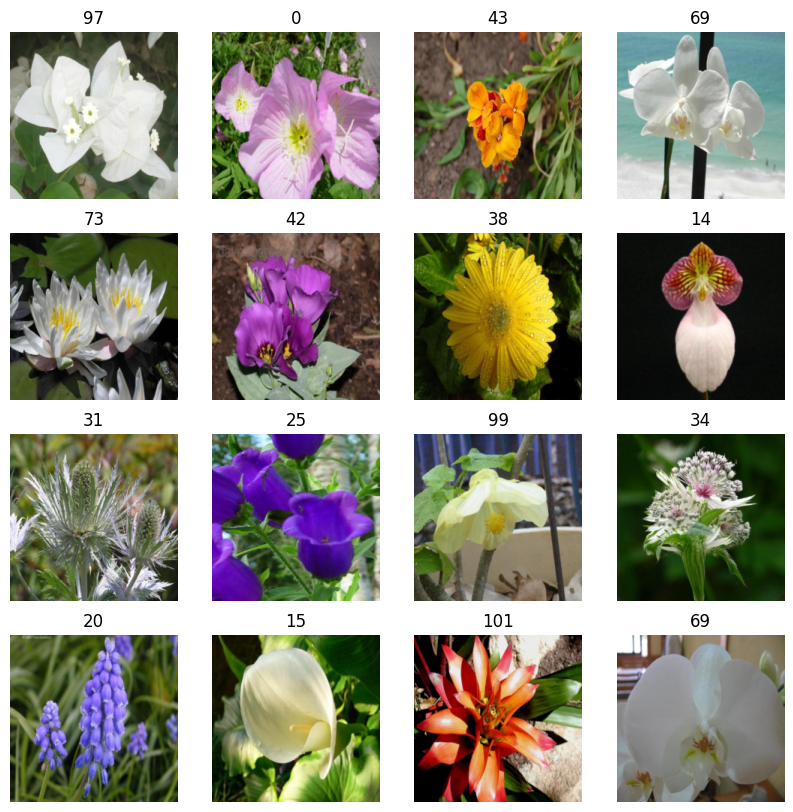

In [12]:
images, labels = next(iter(dataloaders['train']))

def plot(images, labels, nrows=4, ncols=4):
  fig, axes = plt.subplots(nrows, ncols, figsize=(10,10))
  idx = 0
  for i in range(nrows):
    for j in range(ncols):
      ax = axes[i,j]
      ax.imshow(images[idx].cpu().permute(1,2,0))
      label = labels[idx]
      # Handles tensor labels
      if type(labels[idx]) == torch.Tensor:
        label = label.cpu().item()
      # Handles text labels separated with commas
      else:
        splitted = label.split(',')
        if len(splitted) > 1:
          print(label)
          label = splitted[0]
      ax.set_title(label)
      ax.axis('off')
      idx += 1
  plt.show()

plot(images, labels)

In [13]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            data_iter = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Progress")

            for inputs, labels in data_iter:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                data_iter.set_postfix(loss=loss.item())

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

num_epochs = 10
model = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:38<00:00,  1.67it/s, loss=3.27]


train Loss: 4.2870 Acc: 0.0980


Val Progress: 100%|██████████| 64/64 [00:12<00:00,  4.93it/s, loss=3.26]


val Loss: 3.0545 Acc: 0.3882
Epoch 2/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:39<00:00,  1.60it/s, loss=1.49]


train Loss: 1.8575 Acc: 0.6961


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.81it/s, loss=2.02]


val Loss: 1.4189 Acc: 0.7608
Epoch 3/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s, loss=0.288]


train Loss: 0.4583 Acc: 0.9745


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.74it/s, loss=0.915]


val Loss: 0.8631 Acc: 0.8529
Epoch 4/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, loss=0.0725]


train Loss: 0.0904 Acc: 1.0000


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.66it/s, loss=0.515]


val Loss: 0.6110 Acc: 0.8892
Epoch 5/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:39<00:00,  1.64it/s, loss=0.0294]


train Loss: 0.0328 Acc: 1.0000


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.76it/s, loss=0.323]


val Loss: 0.5446 Acc: 0.8941
Epoch 6/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, loss=0.0209]


train Loss: 0.0226 Acc: 1.0000


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.62it/s, loss=0.203]


val Loss: 0.5383 Acc: 0.8971
Epoch 7/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, loss=0.0246]


train Loss: 0.0216 Acc: 1.0000


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.78it/s, loss=0.303]


val Loss: 0.5338 Acc: 0.8990
Epoch 8/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, loss=0.0206]


train Loss: 0.0208 Acc: 1.0000


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.73it/s, loss=0.706]


val Loss: 0.5311 Acc: 0.9000
Epoch 9/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, loss=0.0192]


train Loss: 0.0200 Acc: 1.0000


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.75it/s, loss=0.638]


val Loss: 0.5283 Acc: 0.9000
Epoch 10/10
--------------------


Train Progress: 100%|██████████| 64/64 [00:39<00:00,  1.63it/s, loss=0.0184]


train Loss: 0.0193 Acc: 1.0000


Val Progress: 100%|██████████| 64/64 [00:13<00:00,  4.74it/s, loss=0.743]

val Loss: 0.5258 Acc: 0.8990
Training complete in 8m 47s
Best Validation Accuracy: 0.9000
